# gpOptimizer: Single-Task

In [1]:
## First, install the right version of gpCAM
#!pip install gpcam==8.3.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

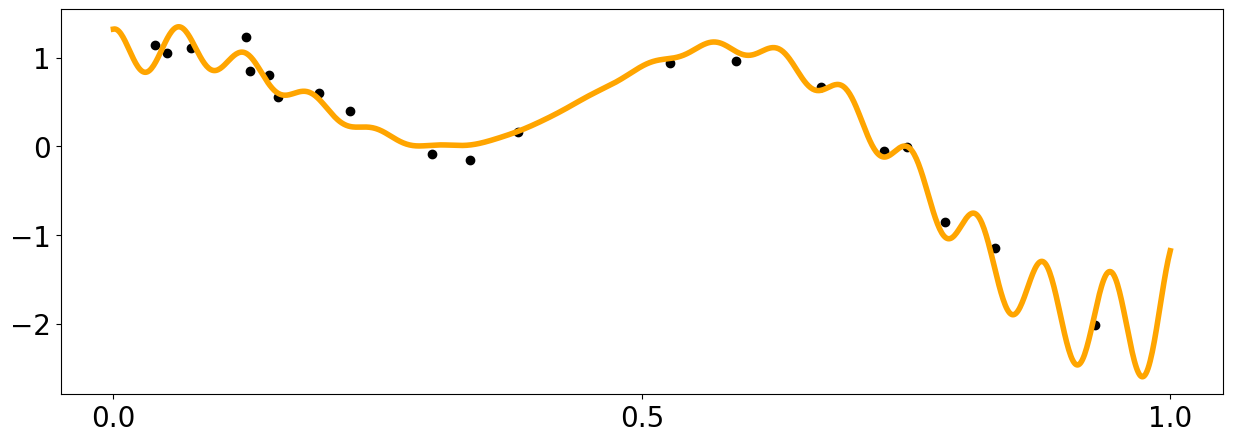

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(20).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

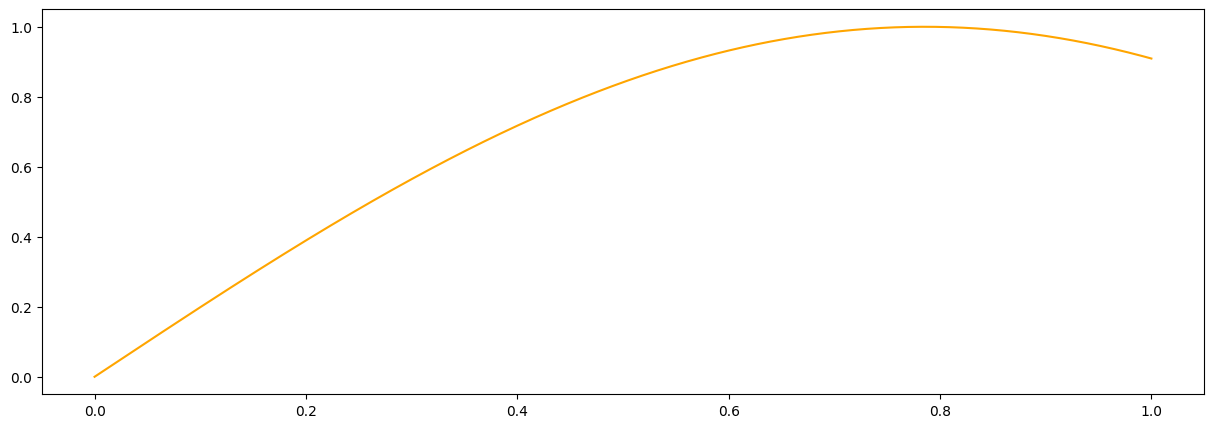

In [5]:
from gpcam.kernels import *
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function can return a matrix or a vector. 
    return np.zeros((len(x))) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [6]:


my_gp1 = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            kernel_function=skernel, 
            kernel_function_grad=None, 
            prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,1.],  #noise
                       [0.01,1.]  #mean
                      ])


my_gp1.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)
print("Standard Training (=MCMC)")
my_gp1.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.hyperparameters)
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.hyperparameters)
print("HGDL Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10, dask_client=client)


Standard Training (=MCMC)
Global Training


/tmp/ipykernel_1110831/2448789629.py:28: DeprecationWarning: `get_hyperparameters()` is deprecated. Please use `hyperparameters`
  print("hps: ", my_gp1.get_hyperparameters())
/tmp/ipykernel_1110831/2448789629.py:31: DeprecationWarning: `get_hyperparameters()` is deprecated. Please use `hyperparameters`
  print(my_gp1.get_hyperparameters())


hps:  [1.12453973 0.17635904 0.15685918 0.01005475]
Local Training
[1.12455973 0.17614549 0.15685918 0.01005463]
HGDL Training


array([1.12533946, 0.17613473, 0.68161009, 0.01      ])

In [7]:
my_gp1.get_data()

{'input dim': 1,
 'x data': array([[0.05033075],
        [0.07352935],
        [0.52658461],
        [0.12935108],
        [0.58910651],
        [0.9287489 ],
        [0.75073949],
        [0.72959827],
        [0.03949984],
        [0.7866517 ],
        [0.12561115],
        [0.38324579],
        [0.15530823],
        [0.30155464],
        [0.22385831],
        [0.19463272],
        [0.83405451],
        [0.14698722],
        [0.6695911 ],
        [0.33726683],
        [0.05033075],
        [0.07352935],
        [0.52658461],
        [0.12935108],
        [0.58910651],
        [0.9287489 ],
        [0.75073949],
        [0.72959827],
        [0.03949984],
        [0.7866517 ],
        [0.12561115],
        [0.38324579],
        [0.15530823],
        [0.30155464],
        [0.22385831],
        [0.19463272],
        [0.83405451],
        [0.14698722],
        [0.6695911 ],
        [0.33726683]]),
 'y data': array([ 1.05219513,  1.10894007,  0.94198474,  0.8510397 ,  0.95556684,
        

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [8]:
my_gp1.set_hyperparameters(np.ones((4))/10.)
print("starting with: ",my_gp1.get_hyperparameters())
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds, dask_client=client)
print("still git: ", my_gp1.get_hyperparameters())
for i in range(20):
    time.sleep(0.01)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.get_hyperparameters())
my_gp1.stop_training(opt_obj)

/tmp/ipykernel_1110831/1360445996.py:2: DeprecationWarning: `get_hyperparameters()` is deprecated. Please use `hyperparameters`
  print("starting with: ",my_gp1.get_hyperparameters())
/tmp/ipykernel_1110831/1360445996.py:4: DeprecationWarning: `get_hyperparameters()` is deprecated. Please use `hyperparameters`
  print("still git: ", my_gp1.get_hyperparameters())
/home/marcus/Coding/fvGP/fvgp/gp_training.py:149: UserWarning:      Hyperparameter update failed with ERROR: list index out of range
  warnings.warn("     Hyperparameter update failed with ERROR: " + str(err))
/tmp/ipykernel_1110831/1360445996.py:8: DeprecationWarning: `get_hyperparameters()` is deprecated. Please use `hyperparameters`
  print(my_gp1.get_hyperparameters())


starting with:  [0.1 0.1 0.1 0.1]
still git:  [0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]
[1.12533764 0.17613445 0.8201407  0.01      ]


## Plotting the Result

0.20411273680829967
(np.float64(0.11448967424129987), np.float64(0.11119257982703153))


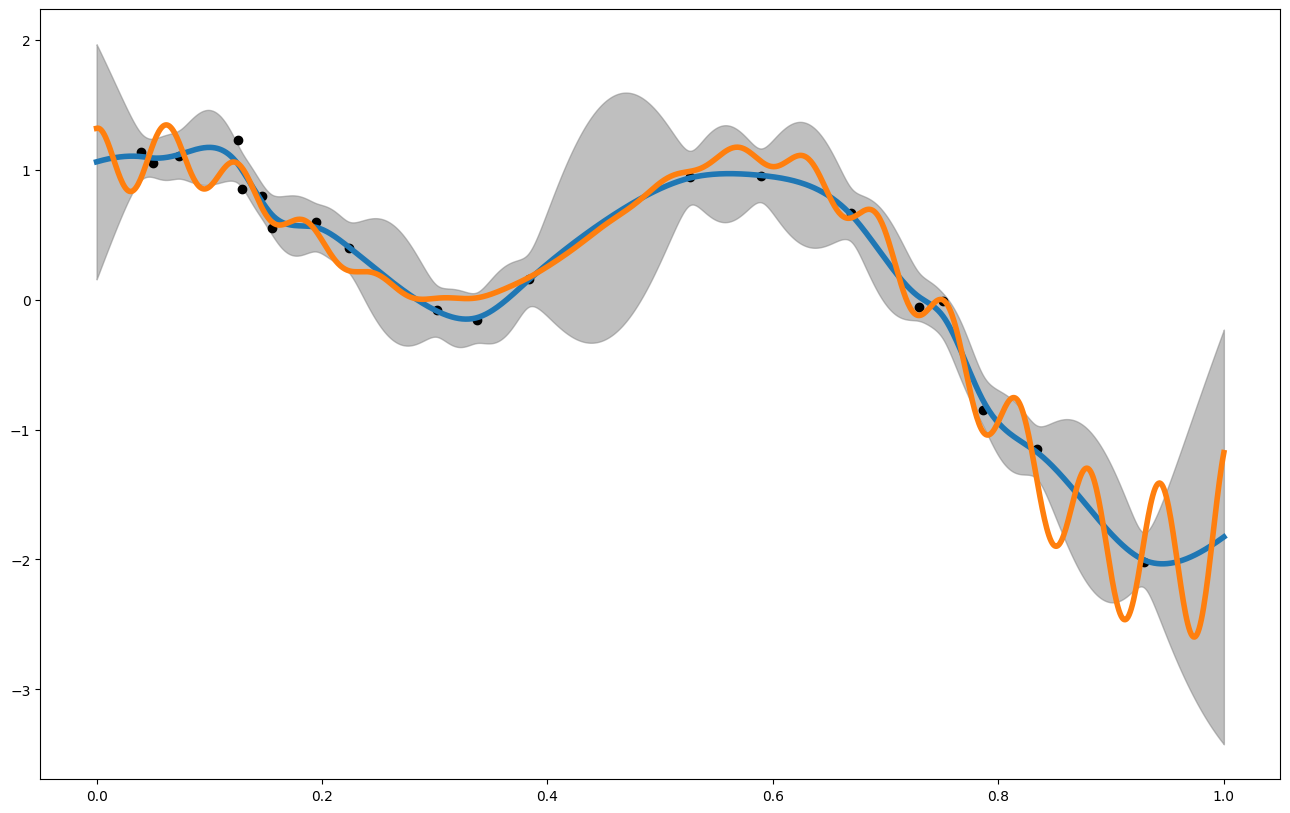

In [10]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D).flatten()))
print(my_gp1.crps(x_pred1D,f1(x_pred1D).flatten()))

In [11]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("Mutual Information: ",my_gp1.gp_mutual_information(x_test))
print("Total Correlation : ",my_gp1.gp_total_correlation(x_test))

Mutual Information:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(1.2903034838977305)}
Total Correlation :  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(11.364404392089185)}


In [12]:
next_point = my_gp1.ask(np.array([[0.,1.]]))
print(next_point)

{'x': array([[0.99999505]]), 'f_a(x)': array([0.53218427]), 'opt_obj': None}
